In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
read_counts = '/Users/jolsen98/Desktop/GSS_atacseq/QC_2_16_24_ADA_true/merged_chr_info.csv'
bulk_qc = '/Users/jolsen98/Desktop/GSS_atacseq/QC_2_16_24_ADA_true/qc2tsv_out.tsv'

In [3]:
read_counts = pd.read_csv(read_counts)
bulk_qc = pd.read_csv(bulk_qc, sep = '\t')
bulk_qc.rename(columns = {'general.title':'gss_id'}, inplace=True)

In [4]:
#No duplicate IDs in bulk_qc file (could be caused by issue with croo when used after multiple atac runs in same directory)
#If this happens, rm -rf croo/* and rerun croo2qc2tsv.sh 
assert (bulk_qc['gss_id'].value_counts().values == 1).all()

In [5]:
def get_numeric_qcs(bulk_qc):
    numeric_qcs = []
    for col in bulk_qc.columns:
        if (bulk_qc[col].dtype == 'int64' or bulk_qc[col].dtype == 'float64') and not (bulk_qc[col] == 0).all():
            numeric_qcs.append(col)
            
    return numeric_qcs

def populate_expected(bulk_qc_df, qc_expected_dict):
    bulk_qc = bulk_qc_df
    qc_expected = qc_expected_dict
    
    new_row_idx = len(bulk_qc)
    
    bulk_qc.at[new_row_idx, 'gss_id'] = 'EXPECTED'
    
    for qc_id in qc_expected.keys():
        bulk_qc.at[new_row_idx, qc_id] = qc_expected_dict[qc_id][0]
        
    return bulk_qc

def plot_column_bar(df,id_col='gss_id', column=None, highlight_ids = []):
    df = df.sort_values(by=column, ascending=True)
    
    palette_dict = {gss_id:None for gss_id in df[id_col].values.tolist()}
    for gss_id in palette_dict.keys():
        if gss_id == 'EXPECTED':
            palette_dict[gss_id] = '#FF0000'
        elif gss_id in highlight_ids:
            palette_dict[gss_id] = '#FFF946'
        else:
            palette_dict[gss_id] = '#B0C0E0'
    
    palette = list(palette_dict.values())
               
            
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column, y=id_col, data=df, palette=palette)
    plt.xlabel(column)
    plt.ylabel('GSS ID')
    plt.title(f'{column} by GSS ID')
    plt.grid(axis='x')
    
    plt.yticks(fontsize=5.5)

    plt.show()
    
    if column in qc_expected.keys():
        print(qc_expected[column][1])

def init_qc_status_df(qc_expected):
    cols = list(qc_expected.keys())
    cols.insert(0,'gss_id')
    qc_status = pd.DataFrame(columns = cols)
    qc_status['gss_id'] = bulk_qc['gss_id']
    return qc_status

def plot_qc_flag_summary(qc_status):
    df = pd.DataFrame()
    df = pd.concat([df, qc_status])
    df = df[~df.isin(['EXPECTED']).any(axis=1)]

    #Add non numeric QC pass/fails
    for col in ['align.frag_len_stat.nfr_peak_exists', 'align.frag_len_stat.mono_nuc_peak_exists', 'align.frag_len_stat.di_nuc_peak_exists']:
        df[col] = df['gss_id'].map(bulk_qc.set_index('gss_id')[col])
        df[col] = df[col].map({True:'Passed', False: "Failed"})

    df.set_index('gss_id', inplace=True)
    value_to_int = {'Passed': 0, 'Failed': 1}


    df['passed_count'] = (df == 'Passed').sum(axis=1)
    df = df.sort_values(by='passed_count', ascending=False)
    df.drop(columns = ['passed_count'], inplace=True)
    passed_counts = (df == 'Passed').sum()

    # Passed QC descending order and on the left
    #sorted_columns = passed_counts.sort_values(ascending=False).index
    sorted_columns = sorted(df.columns.tolist())
    df = df[sorted_columns]

    plt.figure(figsize=(12, 8))

    n = len(value_to_int) 

    # discrete colormap (n samples from a given cmap)
    cmap = sns.color_palette("Pastel2", n) 
    ax = sns.heatmap(df.replace(value_to_int), cmap=cmap, linewidths=0.005, linecolor='black') 

    # Colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys())) 

    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=6.5)

    qc_categories = list(set([item.split(".")[0] for item in df.columns.tolist()]))  
    color_dict = {
        'align': 'red',
        'align_enrich': 'green',
        'lib_complexity': 'blue',
        'peak_enrich': 'orange',
        'replication': 'purple'
    }
    for category in qc_categories:
        category_labels = [item for item in df.columns.tolist() if category in item]
        for label in category_labels:
            idx = int(df.columns.tolist().index(label))
            ax.get_xticklabels()[idx].set_color(color_dict[category])



    plt.show()
    
def highlight_gss_ids_qc(bulk_qc, gss_ids, qc_id):
    plot_column_bar(bulk_qc, id_col='gss_id', column=qc_id, highlight_ids = gss_ids)
    
    return

In [6]:
qc_expected = {
    "align.frag_len_stat.frac_reads_in_nfr" : [0.4, "fraction of reads in nucelosome-free region. Should be a value greater than 0.4"],
    "align.frag_len_stat.nfr_over_mono_nuc_reads" : [2.5, "double, reads in nucleosome-free-region versus reads in mononucleosomal peak. Should be a value greater than 2.5"],
    "lib_complexity.lib_complexity.NRF" : [0.9, "non-reduandant fraction. Measure of library complexity. Ideally >0.9"],
    "lib_complexity.lib_complexity.PBC1" : [0.9, "PCR bottlenecking coefficient 1. Measure of library complexity. Ideally >0.9.\n\t< 0.7 : Severe\n\t0.7 ≤ PBC1 ≤ 0.9 : Moderate\n\t> 0.9 : None "],
    "lib_complexity.lib_complexity.PBC2" : [3.0, "PCR bottlenecking coefficient 2. Measure of library complexity. Ideally >3"],
    "peak_enrich.frac_reads_in_peaks.macs2.rep1-pr1.frip" : [0.3, "The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure."],
    "peak_enrich.frac_reads_in_peaks.macs2.rep1-pr2.frip" : [0.3, "The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure."],
    "peak_enrich.frac_reads_in_peaks.macs2.frip" : [0.3, "The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure."],
    "peak_enrich.frac_reads_in_peaks.overlap.rep1-pr1_vs_rep1-pr2.frip" : [0.3, "The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure."],
    "peak_enrich.frac_reads_in_peaks.idr.rep1-pr1_vs_rep1-pr2.frip" : [0.3, "The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure."],
    "align.samstat.pct_properly_paired_reads" : [95, "The alignment rate, or percentage of mapped reads, should be greater than 95%, though values >80% may be acceptable."],
    "replication.reproducibility.overlap.N1" : [80_000, "Cited from MoTrPAC ATAC-Seq SOP. This standard is relaxed."],
    "replication.reproducibility.idr.N1" : [70_000, "The number of peaks within an IDR peak file should be >70,000, though values >50,000 may be acceptable."],
    'align.nodup_samstat.mapped_reads' : [50_000_000, "Each replicate should have 25 million non-duplicate, non-mitochondrial aligned reads for single-end sequencing and 50 million for paired-ended sequencing (i.e. 25 million fragments, regardless of sequencing run type). "],
    "align_enrich.tss_enrich.tss_enrich" : [10, "Open chromatin assays should show enrichment in open chromatin sites, such as TSS's. An average TSS enrichment in human (hg19) is above 6. A strong TSS enrichment is above 10. "]
}

# Align Stats

In [7]:
dist_cols = read_counts.columns.tolist()
dist_cols.remove('gss_id')

In [8]:
read_counts

,gss_id,total_primary_alignments,pct_chrX,pct_chrY,pct_chrM,pct_auto,pct_contig,pct_unmapped
0,GSS115014,156059573,4.368,0.084,1.723,93.306,1.013,0.738
1,GSS115017,142625414,2.363,0.521,2.048,94.472,1.140,1.288
2,GSS119194,112043961,3.819,0.091,9.261,86.344,0.950,1.208
3,GSS119197,125467232,2.143,0.503,7.568,89.220,1.149,1.033
4,GSS126744,126226457,3.565,0.062,5.329,90.640,0.777,0.705
...,...,...,...,...,...,...,...,...
59,GSS298419,125892199,3.684,0.091,11.428,84.313,0.959,0.718
60,GSS298499,111180870,3.554,0.076,7.827,88.088,0.897,0.732
61,GSS299919,109327555,2.796,0.062,20.595,76.223,0.622,0.682
62,GSS779157,121586132,1.957,0.303,14.033,83.390,0.616,1.101


total_primary_alignments


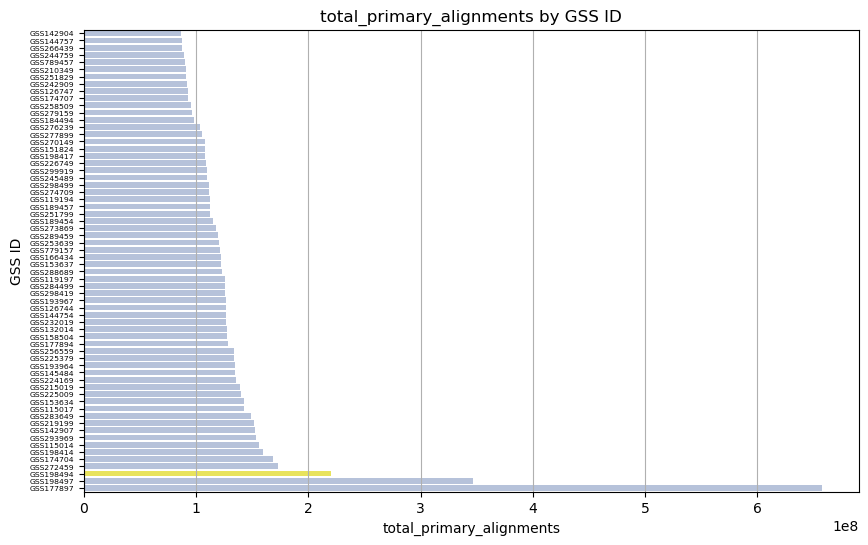

pct_chrX


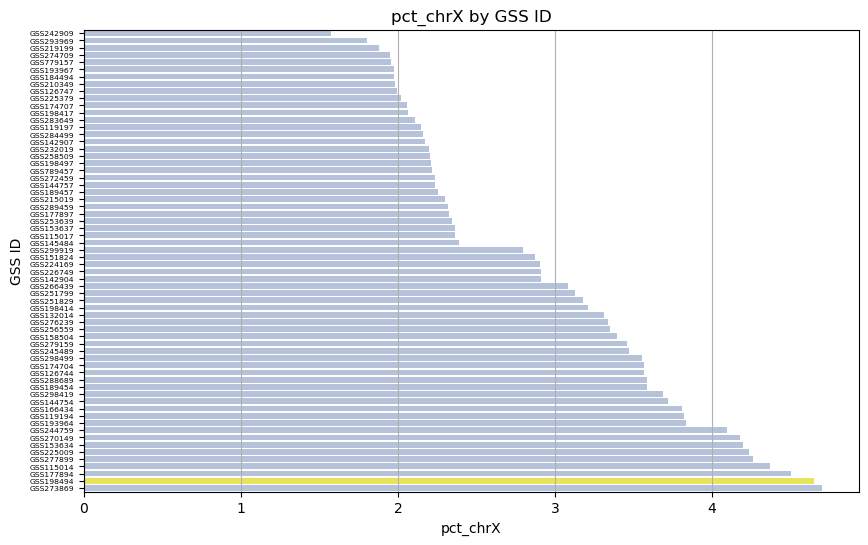

pct_chrY


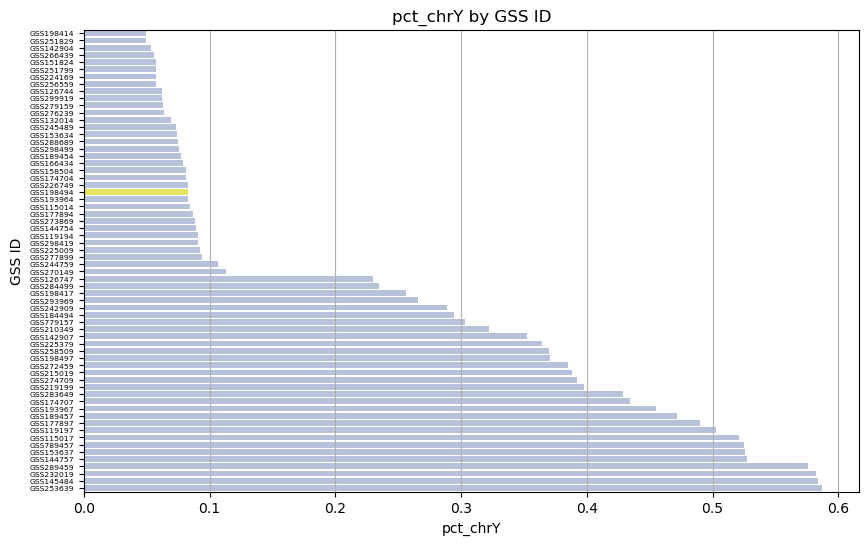

pct_chrM


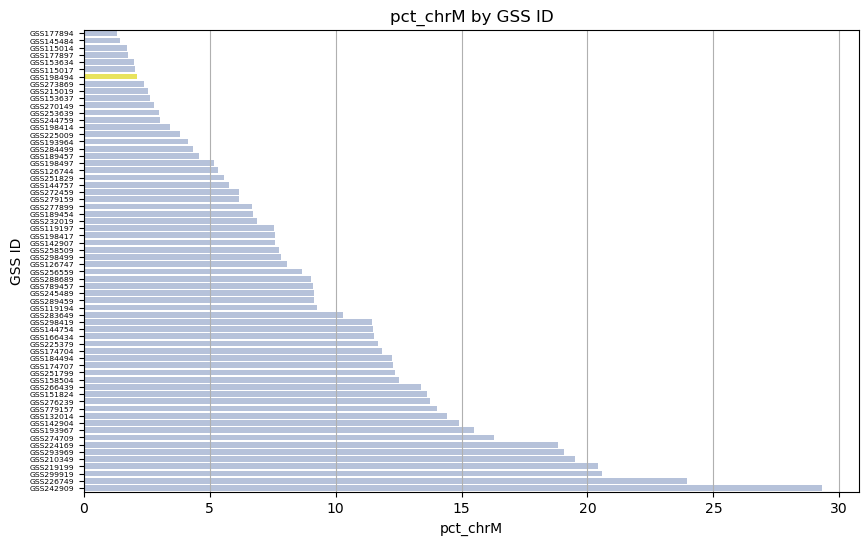

pct_auto


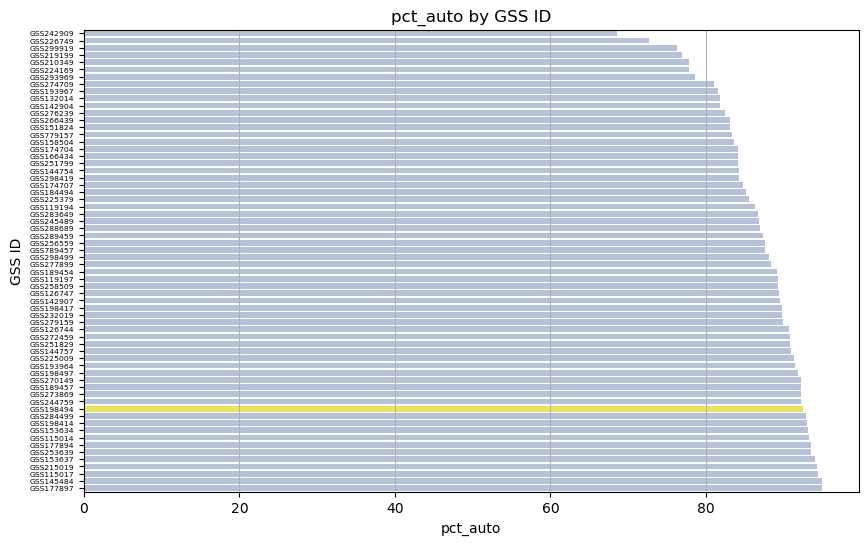

pct_contig


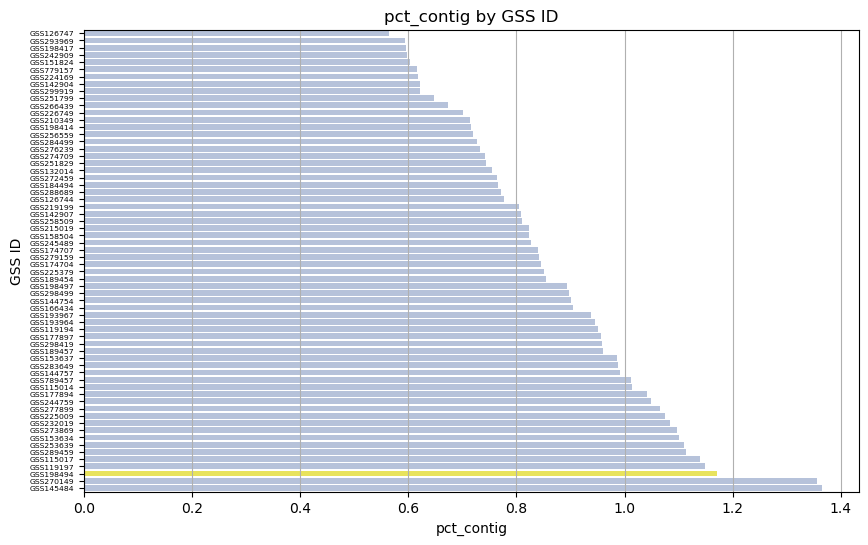

pct_unmapped


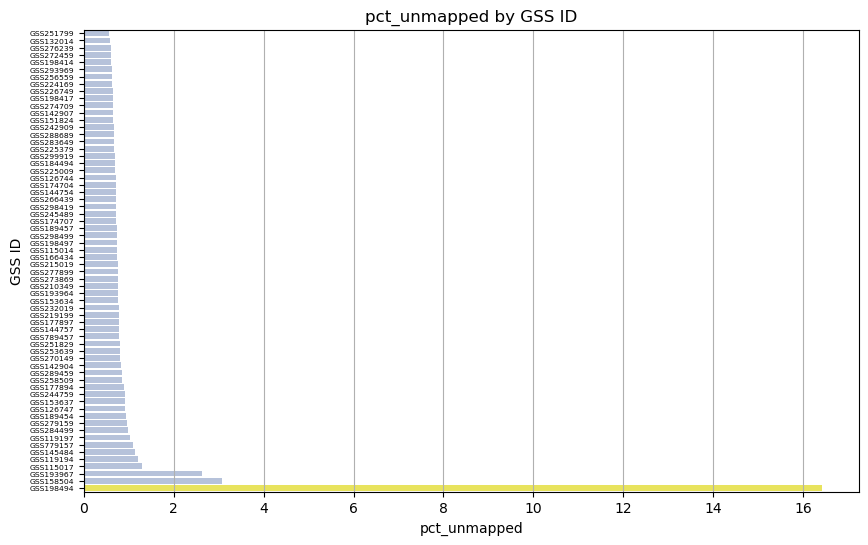

In [9]:
for col in dist_cols: 
    print(col)
    plot_column_bar(read_counts,id_col='gss_id', column=col, highlight_ids = ['GSS198494'])

# Bulk QC (qc2tsv) 

In [10]:
# Add expected value row to bulk_qc dataframe (for visual comparison)
df = populate_expected(bulk_qc, qc_expected)

In [11]:
# Init QC Status df (df of pass/fail labels for each sample and numeric qc metric with a heuristic in qc_expected)
qc_status = init_qc_status_df(qc_expected)

In [12]:
numeric_qcs = [qc for qc in bulk_qc if (bulk_qc[qc].dtype == float or bulk_qc[qc].dtype == int) and (bulk_qc[qc] != 0.0).all()]


In [13]:
len(numeric_qcs)

87

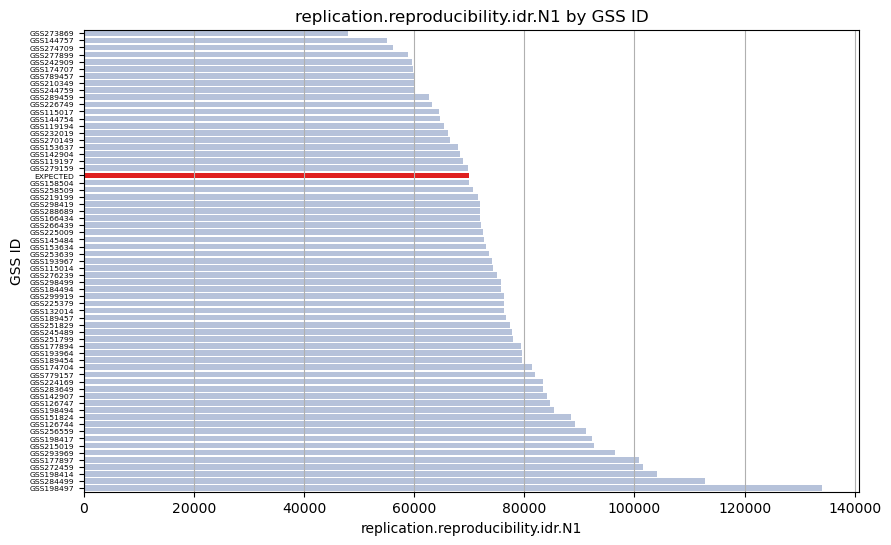

The number of peaks within an IDR peak file should be >70,000, though values >50,000 may be acceptable.


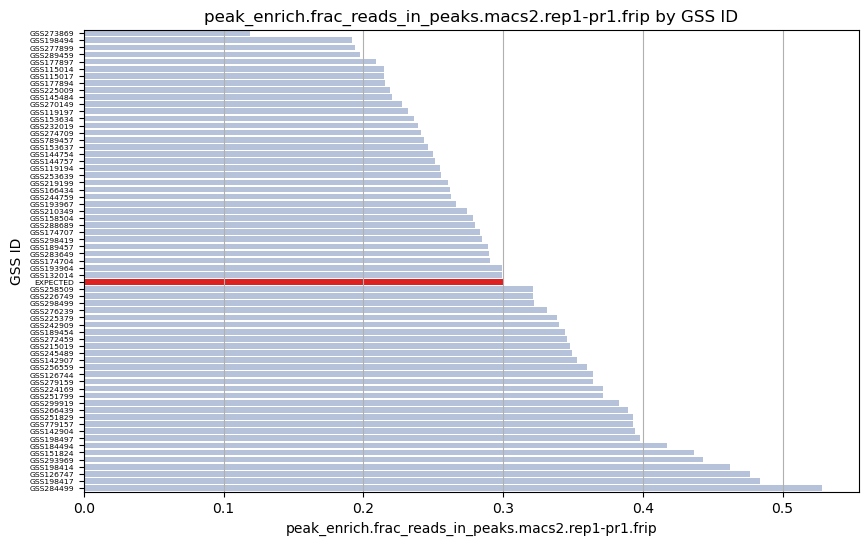

The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure.


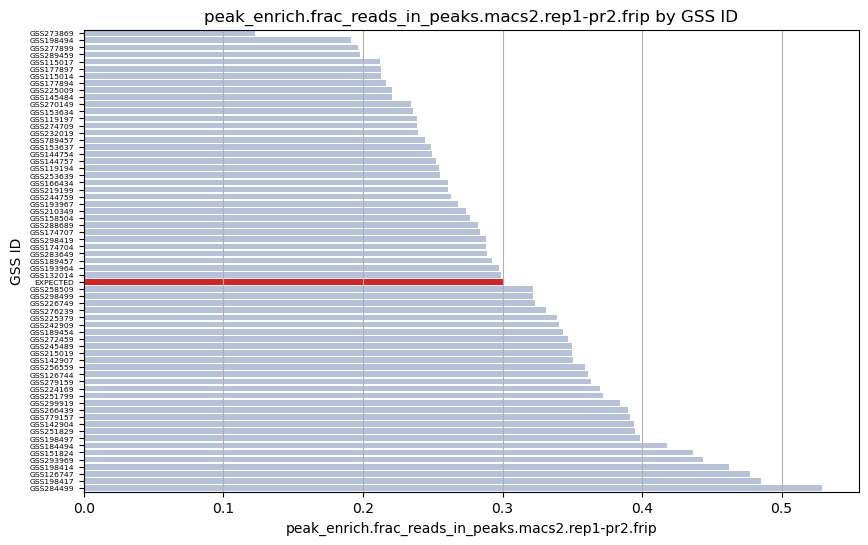

The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure.


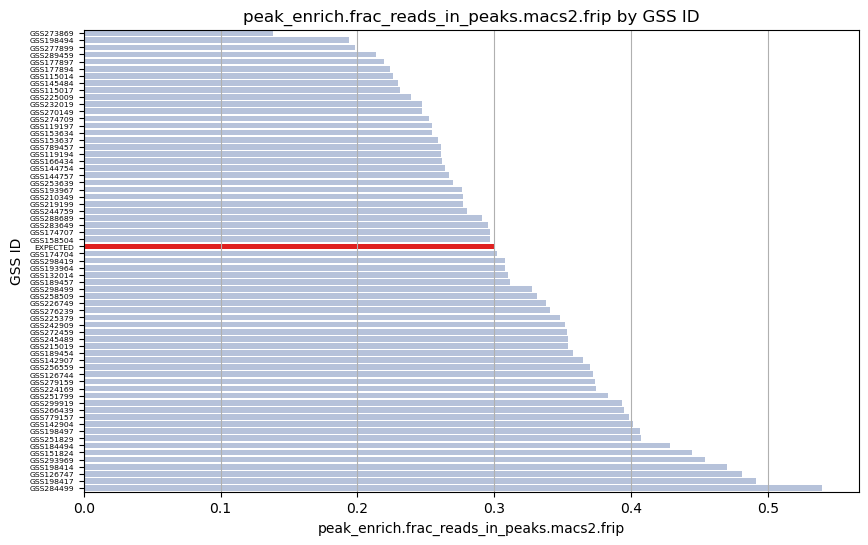

The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure.


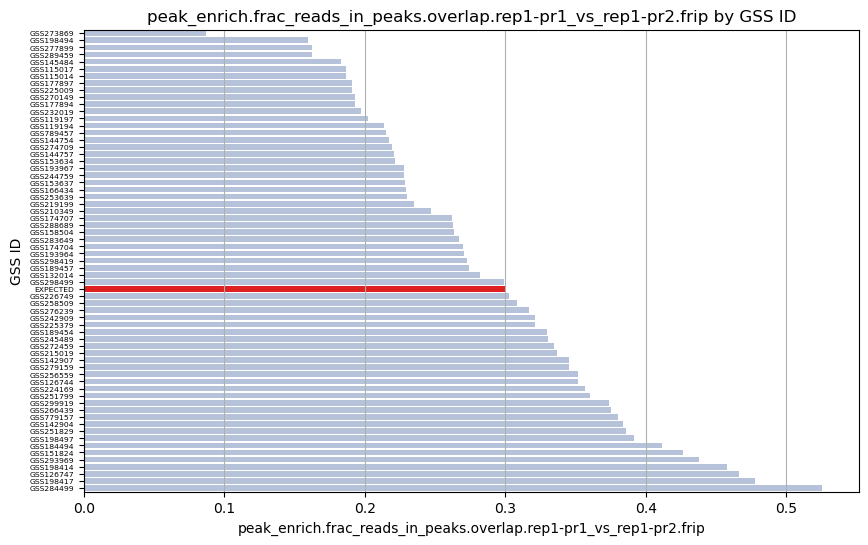

The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure.


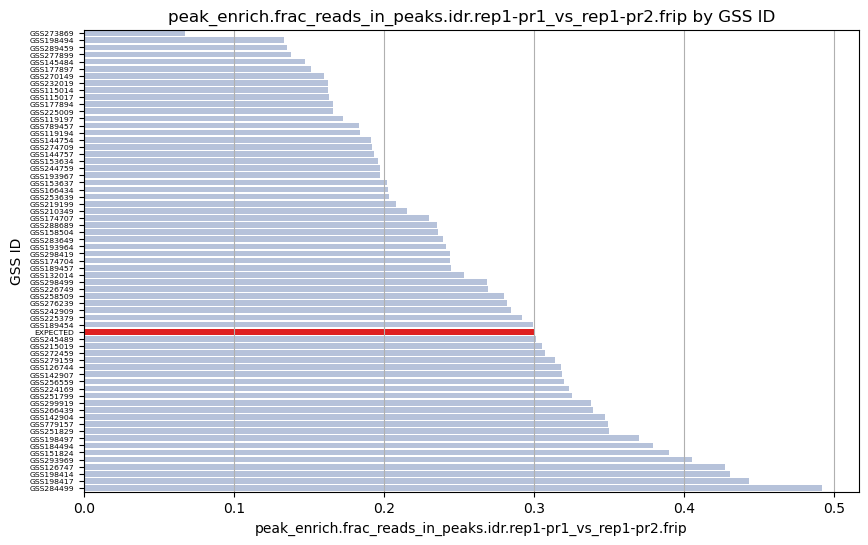

The fraction of reads in called peak regions (FRiP score) should be >0.3, though values greater than 0.2 are acceptable. For EN-TEx tissues, FRiP scores will not be enforced as QC metric. TSS enrichment remains in place as a key signal to noise measure.


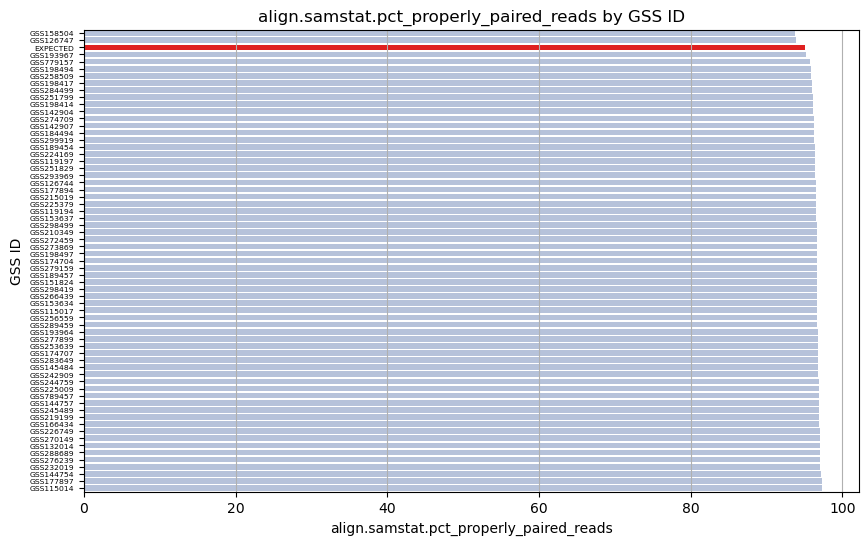

The alignment rate, or percentage of mapped reads, should be greater than 95%, though values >80% may be acceptable.


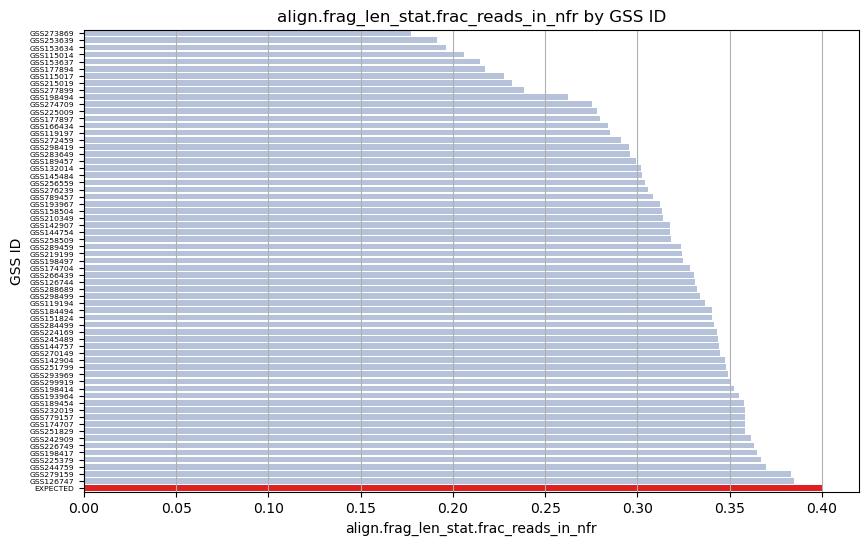

fraction of reads in nucelosome-free region. Should be a value greater than 0.4


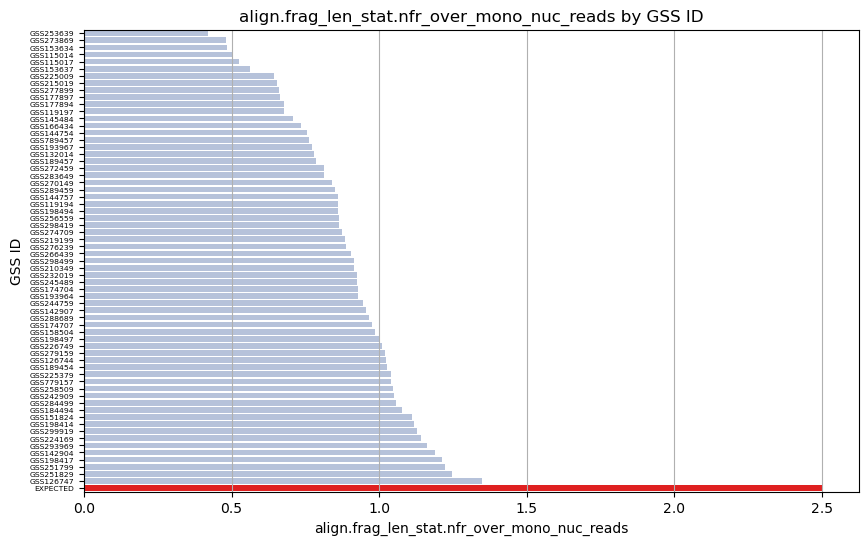

double, reads in nucleosome-free-region versus reads in mononucleosomal peak. Should be a value greater than 2.5


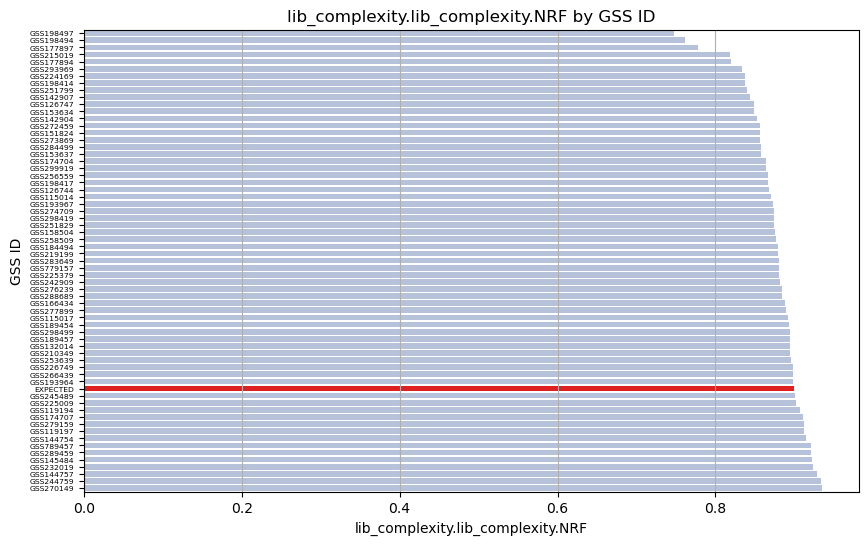

non-reduandant fraction. Measure of library complexity. Ideally >0.9


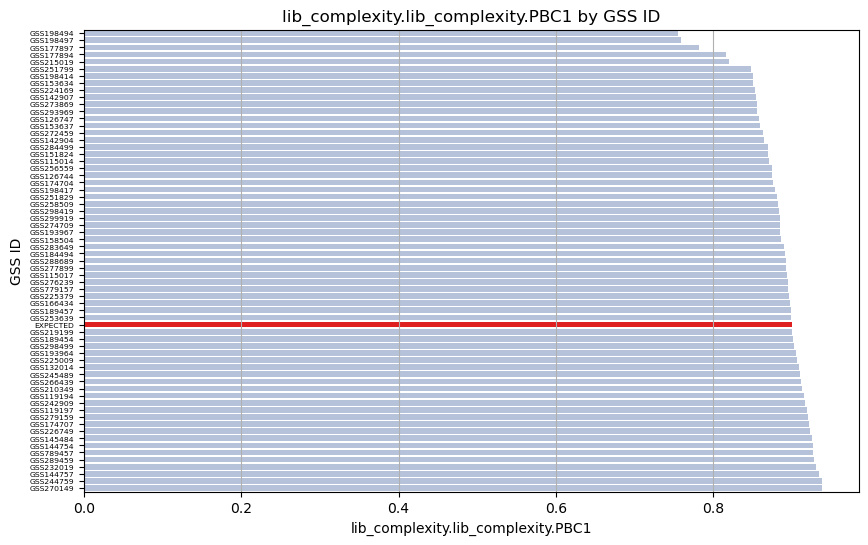

PCR bottlenecking coefficient 1. Measure of library complexity. Ideally >0.9.
	< 0.7 : Severe
	0.7 ≤ PBC1 ≤ 0.9 : Moderate
	> 0.9 : None 


In [14]:
#Plot Failing QCs and update qc_status df
for col in numeric_qcs:
    expected_value = bulk_qc[bulk_qc['gss_id'] == 'EXPECTED'][col].values[0]
    if str(expected_value) =='nan':
        continue
    if (bulk_qc[col] < bulk_qc[bulk_qc['gss_id'] == 'EXPECTED'][col].values[0]).any(): #plot
        plot_column_bar(bulk_qc, id_col='gss_id', column=col)
        
        # Update QC status df
        for gss_id in bulk_qc[bulk_qc[col] < bulk_qc[bulk_qc['gss_id'] == 'EXPECTED'][col].values[0]]['gss_id']:
            idx = qc_status.loc[qc_status['gss_id'] == gss_id].index[0]
            qc_status.at[idx, col] = "Failed"
            
        for gss_id in bulk_qc[bulk_qc[col] >= bulk_qc[bulk_qc['gss_id'] == 'EXPECTED'][col].values[0]]['gss_id']:
            idx = qc_status.loc[qc_status['gss_id'] == gss_id].index[0]
            qc_status.at[idx, col] = "Passed"

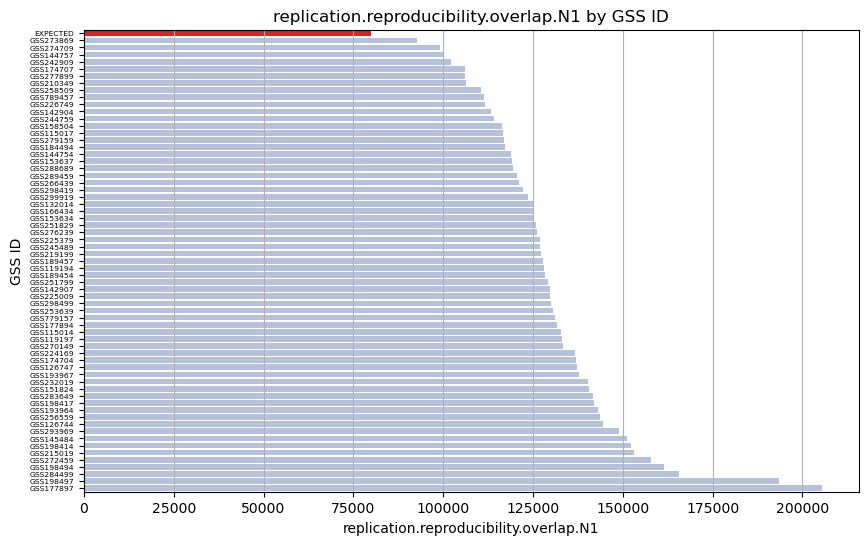

Cited from MoTrPAC ATAC-Seq SOP. This standard is relaxed.


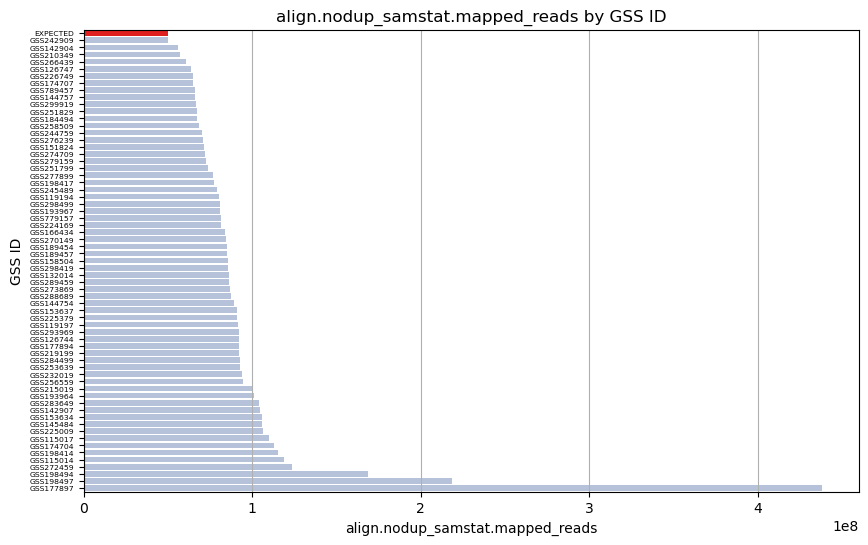

Each replicate should have 25 million non-duplicate, non-mitochondrial aligned reads for single-end sequencing and 50 million for paired-ended sequencing (i.e. 25 million fragments, regardless of sequencing run type). 


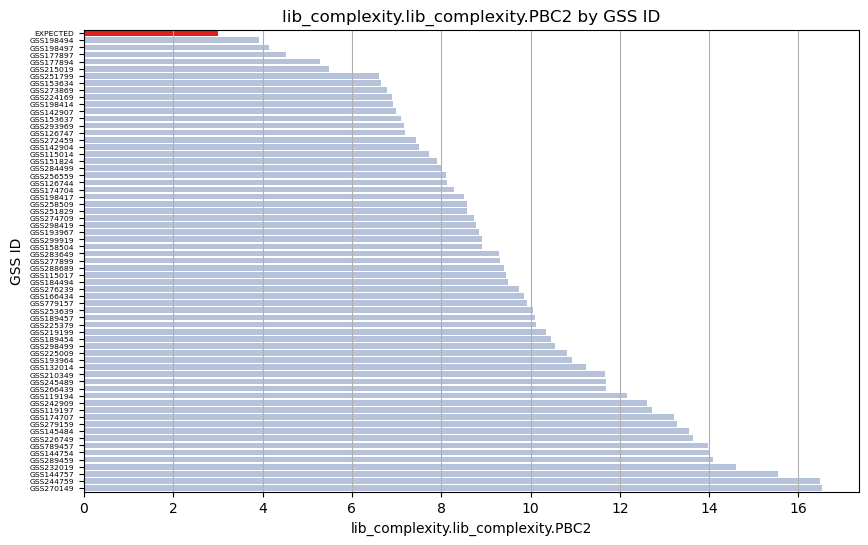

PCR bottlenecking coefficient 2. Measure of library complexity. Ideally >3


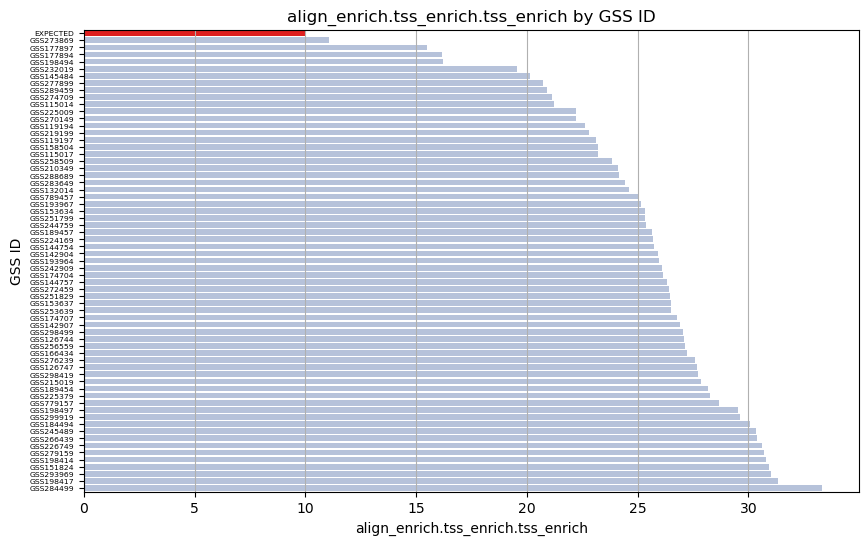

Open chromatin assays should show enrichment in open chromatin sites, such as TSS's. An average TSS enrichment in human (hg19) is above 6. A strong TSS enrichment is above 10. 


In [15]:
#Plot Passing QCs and update qc_status df
for col in numeric_qcs:
    expected_value = bulk_qc[bulk_qc['gss_id'] == 'EXPECTED'][col].values[0]
    if str(expected_value) =='nan':
        continue
    if (bulk_qc[col] >= bulk_qc[bulk_qc['gss_id'] == 'EXPECTED'][col].values[0]).all():
        plot_column_bar(bulk_qc, id_col='gss_id', column=col)
        
        # Update QC status df
        for gss_id in bulk_qc[bulk_qc[col] >= bulk_qc[bulk_qc['gss_id'] == 'EXPECTED'][col].values[0]]['gss_id']:
            idx = qc_status.loc[qc_status['gss_id'] == gss_id].index[0]
            qc_status.at[idx, col] = "Passed"

In [16]:
qc_status

,gss_id,align.frag_len_stat.frac_reads_in_nfr,align.frag_len_stat.nfr_over_mono_nuc_reads,lib_complexity.lib_complexity.NRF,lib_complexity.lib_complexity.PBC1,lib_complexity.lib_complexity.PBC2,peak_enrich.frac_reads_in_peaks.macs2.rep1-pr1.frip,peak_enrich.frac_reads_in_peaks.macs2.rep1-pr2.frip,peak_enrich.frac_reads_in_peaks.macs2.frip,peak_enrich.frac_reads_in_peaks.overlap.rep1-pr1_vs_rep1-pr2.frip,peak_enrich.frac_reads_in_peaks.idr.rep1-pr1_vs_rep1-pr2.frip,align.samstat.pct_properly_paired_reads,replication.reproducibility.overlap.N1,replication.reproducibility.idr.N1,align.nodup_samstat.mapped_reads,align_enrich.tss_enrich.tss_enrich
0,GSS298419,Failed,Failed,Failed,Failed,Passed,Failed,Failed,Passed,Failed,Failed,Passed,Passed,Passed,Passed,Passed
1,GSS132014,Failed,Failed,Failed,Passed,Passed,Failed,Failed,Passed,Failed,Failed,Passed,Passed,Passed,Passed,Passed
2,GSS225379,Failed,Failed,Failed,Failed,Passed,Passed,Passed,Passed,Passed,Failed,Passed,Passed,Passed,Passed,Passed
3,GSS153634,Failed,Failed,Failed,Failed,Passed,Failed,Failed,Failed,Failed,Failed,Passed,Passed,Passed,Passed,Passed
4,GSS225009,Failed,Failed,Passed,Passed,Passed,Failed,Failed,Failed,Failed,Failed,Passed,Passed,Passed,Passed,Passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,GSS293969,Failed,Failed,Failed,Failed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed
61,GSS198417,Failed,Failed,Failed,Failed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed,Passed
62,GSS273869,Failed,Failed,Failed,Failed,Passed,Failed,Failed,Failed,Failed,Failed,Passed,Passed,Failed,Passed,Passed
63,GSS115014,Failed,Failed,Failed,Failed,Passed,Failed,Failed,Failed,Failed,Failed,Passed,Passed,Passed,Passed,Passed


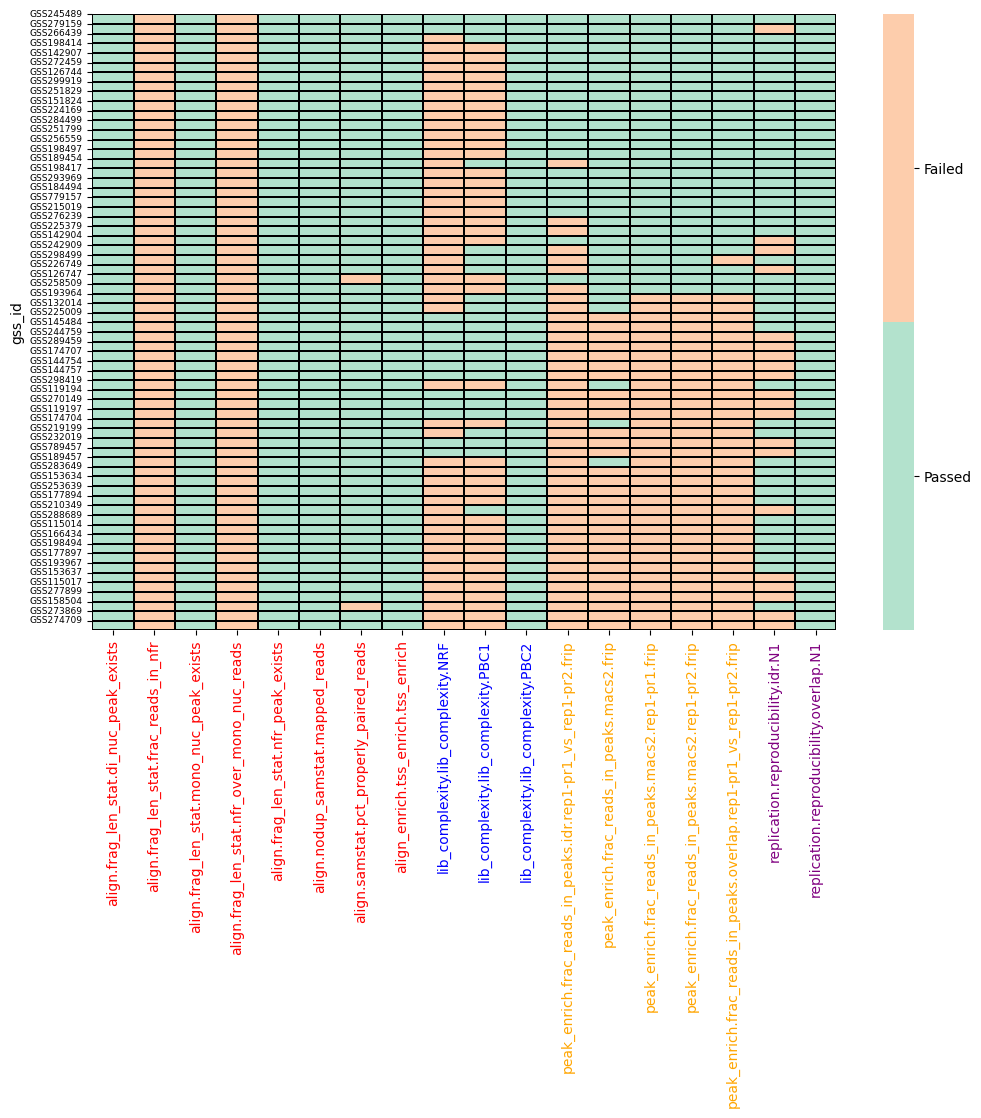

In [17]:
plot_qc_flag_summary(qc_status)

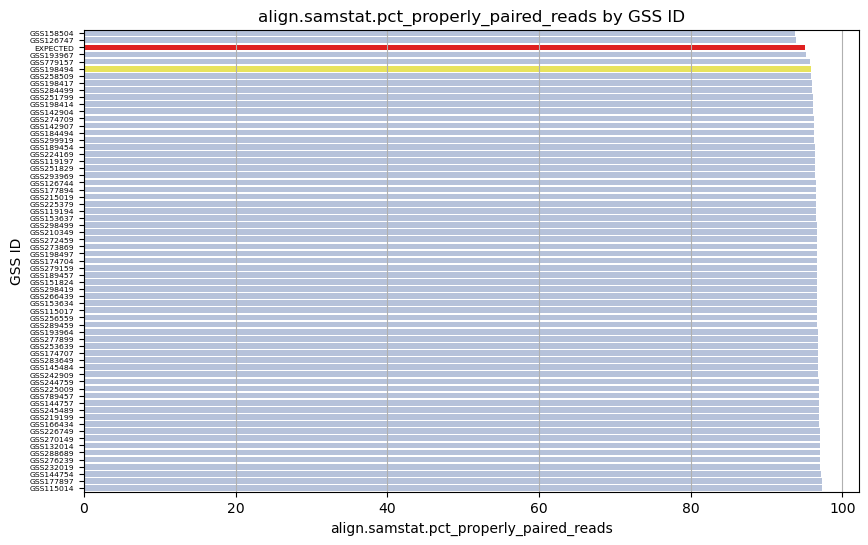

The alignment rate, or percentage of mapped reads, should be greater than 95%, though values >80% may be acceptable.


In [18]:
# Can highlight specific ID's in plots if you want to see where they lie relative to the other samples
highlight_gss_ids_qc(bulk_qc, gss_ids=['GSS198494'], qc_id ='align.samstat.pct_properly_paired_reads')

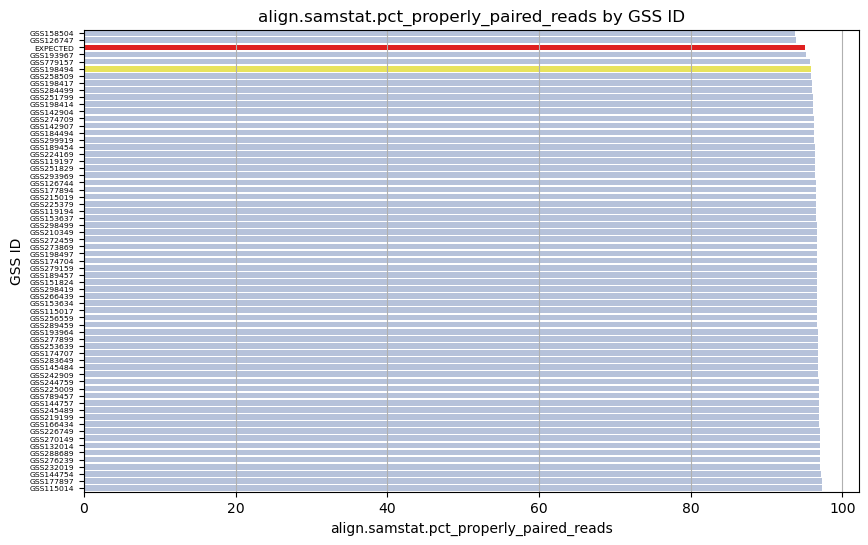

The alignment rate, or percentage of mapped reads, should be greater than 95%, though values >80% may be acceptable.


In [19]:
highlight_gss_ids_qc(bulk_qc, gss_ids=['GSS198494'], qc_id ='align.samstat.pct_properly_paired_reads')

# TODO: Load wetlab QCs and make excel with 4 sheets (2 wetlab, align stats, bulk qc)


### Also find way to save together with pbmc pdf 

In [20]:
bulk_qc = bulk_qc[~bulk_qc.isin(['EXPECTED']).any(axis=1)]

In [21]:
bulk_qc = bulk_qc[['gss_id']+numeric_qcs]

In [22]:
bulk_qc

,gss_id,replication.reproducibility.overlap.N1,replication.reproducibility.overlap.N_opt,replication.reproducibility.overlap.N_consv,replication.reproducibility.overlap.self_consistency_ratio,replication.reproducibility.idr.N1,replication.reproducibility.idr.N_opt,replication.reproducibility.idr.N_consv,replication.reproducibility.idr.self_consistency_ratio,replication.num_peaks.num_peaks,...,align_enrich.xcor_score.min_corr,align_enrich.xcor_score.NSC,align_enrich.xcor_score.RSC,align_enrich.tss_enrich.tss_enrich,align_enrich.jsd.auc,align_enrich.jsd.syn_auc,align_enrich.jsd.x_intercept,align_enrich.jsd.elbow_pt,align_enrich.jsd.syn_elbow_pt,align_enrich.jsd.syn_jsd
0,GSS298419,122313.0,122313.0,122313.0,1.0,71860.0,71860.0,71860.0,1.0,243355.0,...,0.112823,2.575656,1.512960,27.721798,0.213528,0.495980,0.127103,0.719622,0.501424,0.417470
1,GSS132014,125194.0,125194.0,125194.0,1.0,76363.0,76363.0,76363.0,1.0,212006.0,...,0.116583,2.526174,1.545412,24.620775,0.198109,0.495981,0.133253,0.729017,0.498664,0.437735
2,GSS225379,126994.0,126994.0,126994.0,1.0,76274.0,76274.0,76274.0,1.0,216400.0,...,0.109604,3.059291,1.468232,28.265775,0.183791,0.496032,0.132821,0.753773,0.505274,0.466238
3,GSS153634,125306.0,125306.0,125306.0,1.0,73072.0,73072.0,73072.0,1.0,246257.0,...,0.117918,2.131459,1.573479,25.340004,0.241498,0.496421,0.120758,0.674172,0.496739,0.369569
4,GSS225009,129844.0,129844.0,129844.0,1.0,72446.0,72446.0,72446.0,1.0,298550.0,...,0.124052,1.891695,1.602697,22.214611,0.241736,0.496367,0.122607,0.655990,0.502281,0.358765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,GSS193964,143223.0,143223.0,143223.0,1.0,79498.0,79498.0,79498.0,1.0,268696.0,...,0.115170,2.552343,1.495426,25.956002,0.205800,0.496238,0.128441,0.717465,0.506057,0.424400
60,GSS293969,149021.0,149021.0,149021.0,1.0,96439.0,96439.0,96439.0,1.0,196899.0,...,0.098905,3.968253,1.485953,30.999653,0.148180,0.496102,0.137310,0.842864,0.505387,0.539612
61,GSS198417,141953.0,141953.0,141953.0,1.0,92358.0,92358.0,92358.0,1.0,176931.0,...,0.100772,4.152293,1.470696,31.354052,0.125607,0.495741,0.161220,0.865341,0.499460,0.575371
62,GSS273869,92747.0,92747.0,92747.0,1.0,48052.0,48052.0,48052.0,1.0,263925.0,...,0.132307,1.278326,2.746318,11.056796,0.285603,0.496061,0.119656,0.573931,0.502431,0.270734


In [23]:
merged = bulk_qc.merge(read_counts, on = 'gss_id')

In [24]:
merged

,gss_id,replication.reproducibility.overlap.N1,replication.reproducibility.overlap.N_opt,replication.reproducibility.overlap.N_consv,replication.reproducibility.overlap.self_consistency_ratio,replication.reproducibility.idr.N1,replication.reproducibility.idr.N_opt,replication.reproducibility.idr.N_consv,replication.reproducibility.idr.self_consistency_ratio,replication.num_peaks.num_peaks,...,align_enrich.jsd.elbow_pt,align_enrich.jsd.syn_elbow_pt,align_enrich.jsd.syn_jsd,total_primary_alignments,pct_chrX,pct_chrY,pct_chrM,pct_auto,pct_contig,pct_unmapped
0,GSS298419,122313.0,122313.0,122313.0,1.0,71860.0,71860.0,71860.0,1.0,243355.0,...,0.719622,0.501424,0.417470,125892199,3.684,0.091,11.428,84.313,0.959,0.718
1,GSS132014,125194.0,125194.0,125194.0,1.0,76363.0,76363.0,76363.0,1.0,212006.0,...,0.729017,0.498664,0.437735,127144634,3.309,0.069,14.406,81.841,0.754,0.576
2,GSS225379,126994.0,126994.0,126994.0,1.0,76274.0,76274.0,76274.0,1.0,216400.0,...,0.753773,0.505274,0.466238,133848523,2.018,0.364,11.692,85.483,0.851,0.678
3,GSS153634,125306.0,125306.0,125306.0,1.0,73072.0,73072.0,73072.0,1.0,246257.0,...,0.674172,0.496739,0.369569,142527558,4.199,0.074,1.970,93.168,1.100,0.763
4,GSS225009,129844.0,129844.0,129844.0,1.0,72446.0,72446.0,72446.0,1.0,298550.0,...,0.655990,0.502281,0.358765,140371320,4.232,0.092,3.807,91.337,1.074,0.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,GSS193964,143223.0,143223.0,143223.0,1.0,79498.0,79498.0,79498.0,1.0,268696.0,...,0.717465,0.506057,0.424400,134337267,3.833,0.083,4.129,91.481,0.946,0.761
60,GSS293969,149021.0,149021.0,149021.0,1.0,96439.0,96439.0,96439.0,1.0,196899.0,...,0.842864,0.505387,0.539612,153515416,1.804,0.266,19.066,78.577,0.594,0.619
61,GSS198417,141953.0,141953.0,141953.0,1.0,92358.0,92358.0,92358.0,1.0,176931.0,...,0.865341,0.499460,0.575371,108081026,2.063,0.256,7.580,89.815,0.595,0.642
62,GSS273869,92747.0,92747.0,92747.0,1.0,48052.0,48052.0,48052.0,1.0,263925.0,...,0.573931,0.502431,0.270734,117908700,4.699,0.088,2.376,92.240,1.096,0.758


In [52]:
correlation_matrix = merged[merged.columns[1:]].corr()
filtered_correlation_matrix = correlation_matrix[abs(correlation_matrix) >= 0.75]

# Print the correlation matrix
correlation_matrix

,replication.reproducibility.overlap.N1,replication.reproducibility.overlap.N_opt,replication.reproducibility.overlap.N_consv,replication.reproducibility.overlap.self_consistency_ratio,replication.reproducibility.idr.N1,replication.reproducibility.idr.N_opt,replication.reproducibility.idr.N_consv,replication.reproducibility.idr.self_consistency_ratio,replication.num_peaks.num_peaks,peak_stat.peak_region_size.idr_opt.min_size,...,align_enrich.jsd.elbow_pt,align_enrich.jsd.syn_elbow_pt,align_enrich.jsd.syn_jsd,total_primary_alignments,pct_chrX,pct_chrY,pct_chrM,pct_auto,pct_contig,pct_unmapped
replication.reproducibility.overlap.N1,1.000000,1.000000,1.000000,NaN,0.873419,0.873419,0.873419,NaN,0.236043,NaN,...,0.237888,-0.049180,0.165511,0.730450,-0.095325,0.095709,-0.338938,0.371371,0.025167,0.189642
replication.reproducibility.overlap.N_opt,1.000000,1.000000,1.000000,NaN,0.873419,0.873419,0.873419,NaN,0.236043,NaN,...,0.237888,-0.049180,0.165511,0.730450,-0.095325,0.095709,-0.338938,0.371371,0.025167,0.189642
replication.reproducibility.overlap.N_consv,1.000000,1.000000,1.000000,NaN,0.873419,0.873419,0.873419,NaN,0.236043,NaN,...,0.237888,-0.049180,0.165511,0.730450,-0.095325,0.095709,-0.338938,0.371371,0.025167,0.189642
replication.reproducibility.overlap.self_consistency_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
replication.reproducibility.idr.N1,0.873419,0.873419,0.873419,NaN,1.000000,1.000000,1.000000,NaN,-0.152067,NaN,...,0.581640,-0.090558,0.495774,0.504379,-0.164347,-0.061379,-0.197774,0.242227,-0.301904,0.055577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pct_chrY,0.095709,0.095709,0.095709,NaN,-0.061379,-0.061379,-0.061379,NaN,0.311670,NaN,...,-0.238060,0.110971,-0.207103,0.185812,-0.742832,1.000000,-0.114823,0.195377,0.328093,-0.077484
pct_chrM,-0.338938,-0.338938,-0.338938,NaN,-0.197774,-0.197774,-0.197774,NaN,-0.455290,NaN,...,0.304885,-0.010846,0.346418,-0.244741,-0.378061,-0.114823,1.000000,-0.993128,-0.632820,-0.146759
pct_auto,0.371371,0.371371,0.371371,NaN,0.242227,0.242227,0.242227,NaN,0.418798,NaN,...,-0.245810,0.012386,-0.284935,0.260242,0.270610,0.195377,-0.993128,1.000000,0.594511,0.117403
pct_contig,0.025167,0.025167,0.025167,NaN,-0.301904,-0.301904,-0.301904,NaN,0.850264,NaN,...,-0.802412,0.036402,-0.801772,0.131558,0.340385,0.328093,-0.632820,0.594511,1.000000,0.230736


In [53]:
filtered_correlation_matrix

,replication.reproducibility.overlap.N1,replication.reproducibility.overlap.N_opt,replication.reproducibility.overlap.N_consv,replication.reproducibility.overlap.self_consistency_ratio,replication.reproducibility.idr.N1,replication.reproducibility.idr.N_opt,replication.reproducibility.idr.N_consv,replication.reproducibility.idr.self_consistency_ratio,replication.num_peaks.num_peaks,peak_stat.peak_region_size.idr_opt.min_size,...,align_enrich.jsd.elbow_pt,align_enrich.jsd.syn_elbow_pt,align_enrich.jsd.syn_jsd,total_primary_alignments,pct_chrX,pct_chrY,pct_chrM,pct_auto,pct_contig,pct_unmapped
replication.reproducibility.overlap.N1,1.000000,1.000000,1.000000,NaN,0.873419,0.873419,0.873419,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
replication.reproducibility.overlap.N_opt,1.000000,1.000000,1.000000,NaN,0.873419,0.873419,0.873419,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
replication.reproducibility.overlap.N_consv,1.000000,1.000000,1.000000,NaN,0.873419,0.873419,0.873419,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
replication.reproducibility.overlap.self_consistency_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
replication.reproducibility.idr.N1,0.873419,0.873419,0.873419,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pct_chrY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
pct_chrM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.993128,NaN,NaN
pct_auto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.993128,1.000000,NaN,NaN
pct_contig,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.850264,NaN,...,-0.802412,NaN,-0.801772,NaN,NaN,NaN,NaN,NaN,1.0,NaN


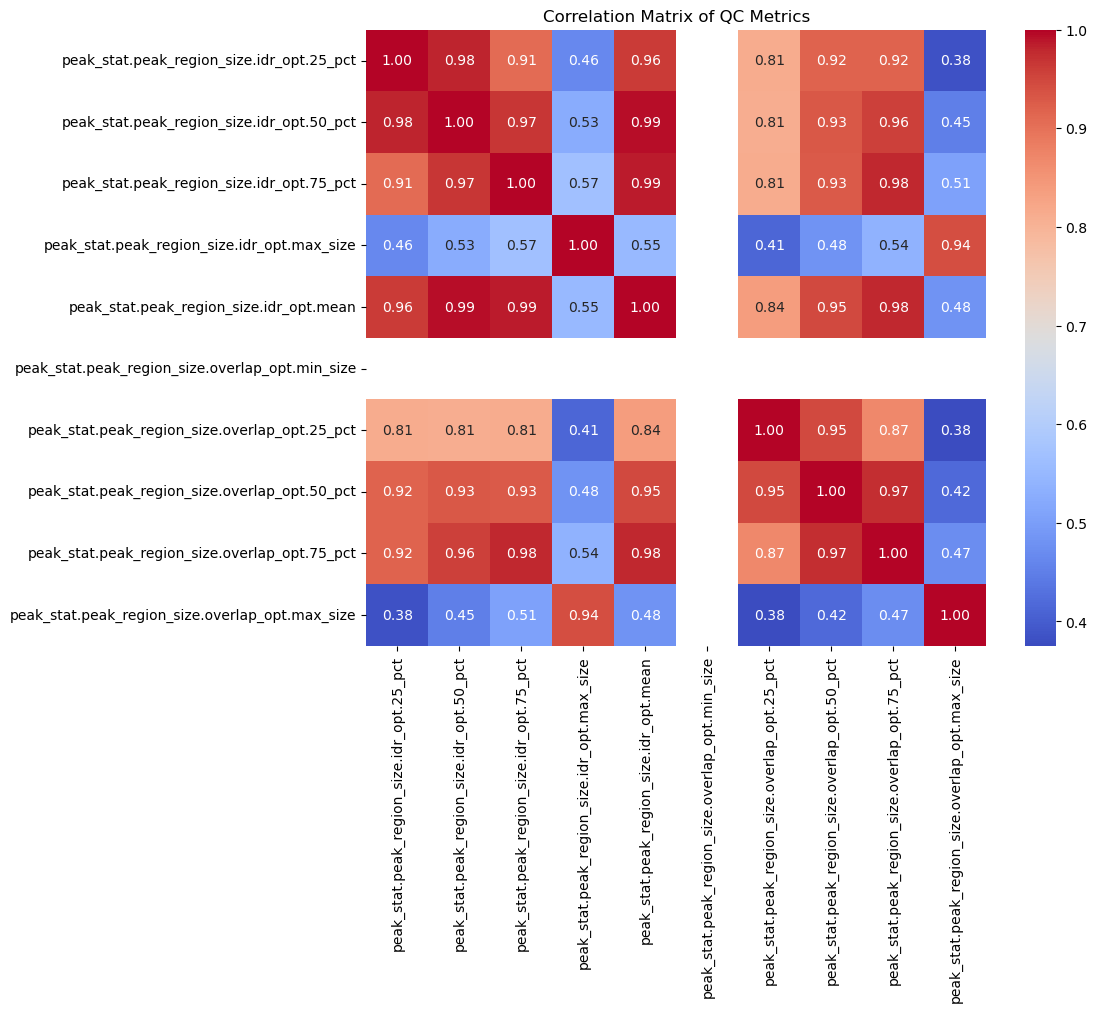

In [54]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.iloc[10:20, 10:20], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of QC Metrics')
plt.show()

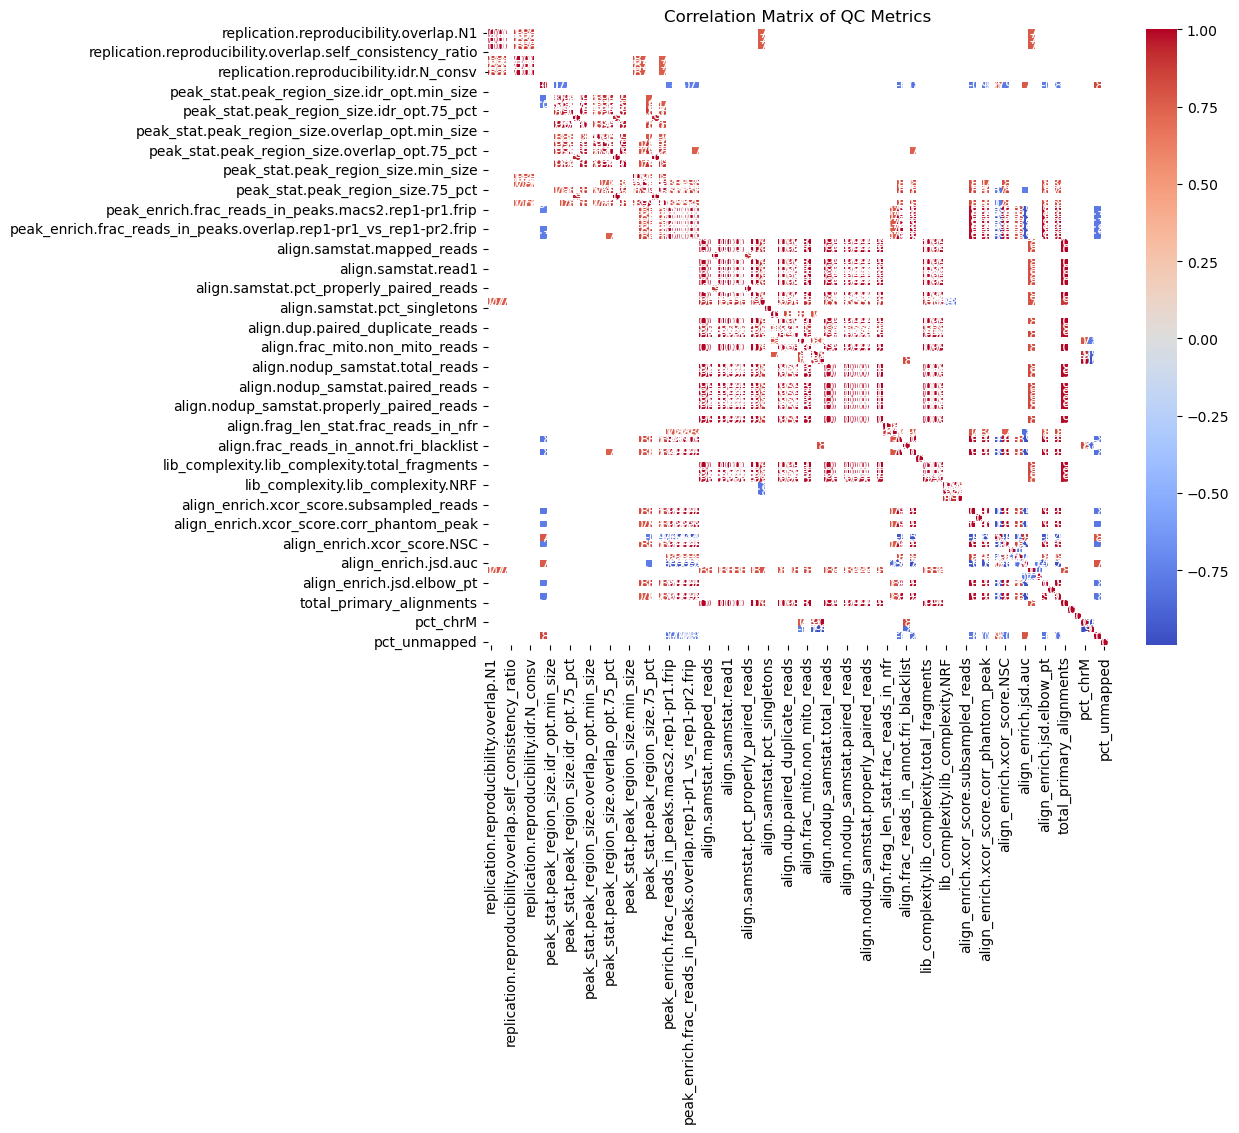

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of QC Metrics')
plt.show()

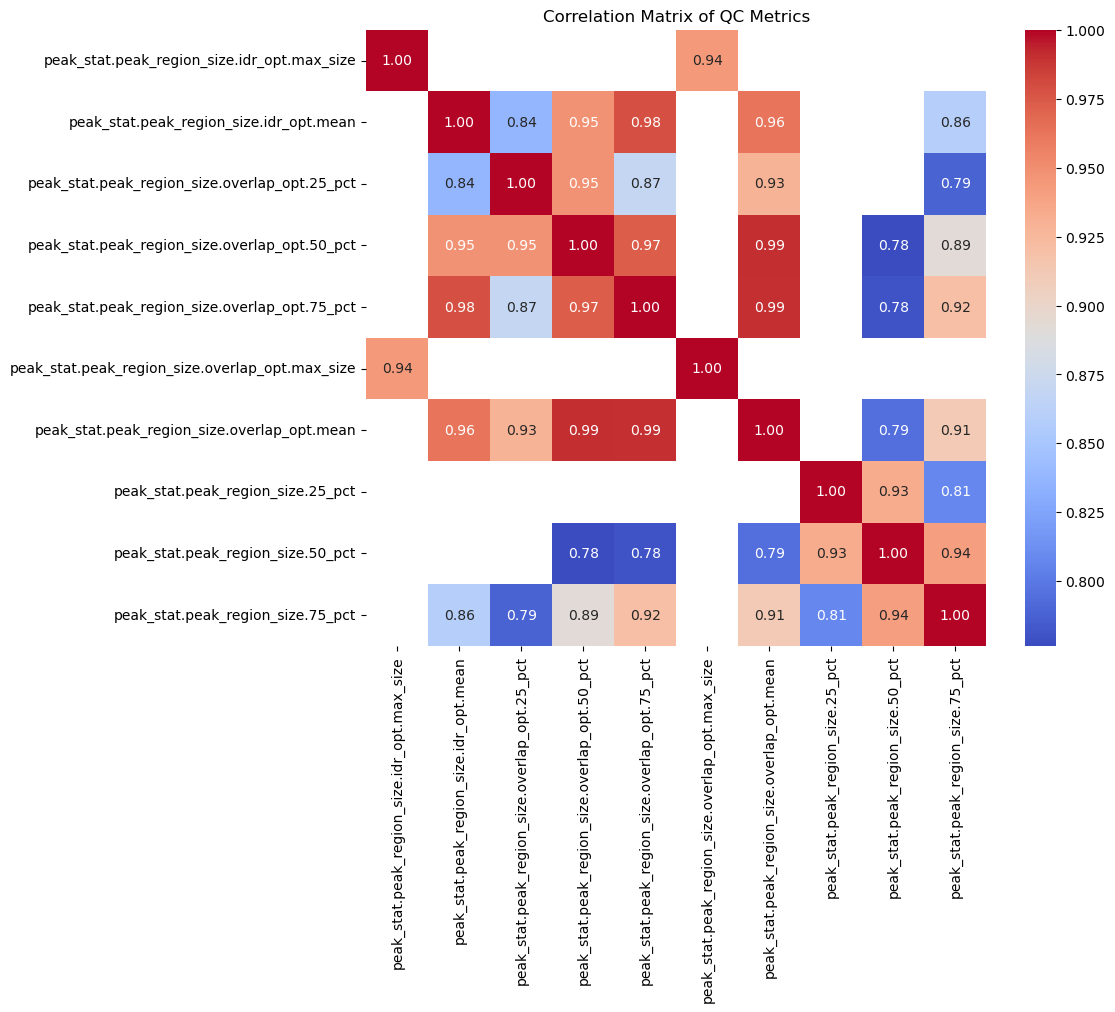

In [57]:
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_correlation_matrix.iloc[10:20, 10:20], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of QC Metrics')
plt.show()

In [27]:
matrix = bulk_qc[qc_status.columns]

In [28]:
matrix = bulk_qc[qc_status.columns]
correlation_matrix = matrix[matrix.columns[1:]].corr()
#filtered_correlation_matrix = correlation_matrix[abs(correlation_matrix) >= 0.75]

# Print the correlation matrix
print(filtered_correlation_matrix)

                                                    replication.reproducibility.overlap.N1  \
replication.reproducibility.overlap.N1                                            1.000000   
replication.reproducibility.overlap.N_opt                                         1.000000   
replication.reproducibility.overlap.N_consv                                       1.000000   
replication.reproducibility.overlap.self_consis...                                     NaN   
replication.reproducibility.idr.N1                                                0.873419   
...                                                                                    ...   
pct_chrY                                                                               NaN   
pct_chrM                                                                               NaN   
pct_auto                                                                               NaN   
pct_contig                                                  

In [30]:
read_counts = '/Users/jolsen98/Desktop/GSS_atacseq/QC_2_16_24_ADA_true/merged_chr_info.csv'
bulk_qc = '/Users/jolsen98/Desktop/GSS_atacseq/QC_2_16_24_ADA_true/qc2tsv_out.tsv'
wetlab_qc = "/Users/jolsen98/Desktop/GSS_atacseq/QC_2_16_24_ADA_true/11-30-23_Library_Summary_PBMC_ATAC_GREGoR.xlsx"

In [31]:
read_counts = pd.read_csv(read_counts)
bulk_qc = pd.read_csv(bulk_qc, sep = '\t')
wetlab_qc1 = pd.read_excel(wetlab_qc, sheet_name='Sheet1')
wetlab_qc2 = pd.read_excel(wetlab_qc, sheet_name='FA')
bulk_qc.rename(columns = {'general.title':'gss_id'}, inplace=True)

In [32]:
wetlab_qc1.drop(columns =['Unnamed: 2'], inplace=True)

In [33]:
wetlab_qc1.columns

Index(['Well', 'Barcode', 'FA, Std. Sens ng/ul', 'FA, SS % Total',
       'FA, SS 100-1500 bp', 'BioA, HS ng/ul', 'BioA, HS size 100-1500 bp',
       'Quibit, HS 2', 'Qubit, HS 2', 'Concentration to use', 'bp to use'],
      dtype='object')

In [34]:
writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')

# Write each dataframe to a separate sheet in the Excel file
read_counts.to_excel(writer, sheet_name='read_counts', index=False)
bulk_qc.to_excel(writer, sheet_name='bulk_qc', index=False)
wetlab_qc1.to_excel(writer, sheet_name='wetlab_qc1', index=False)
wetlab_qc2.to_excel(writer, sheet_name='wetlab_qc2', index=False)

# Save the Excel file
writer.save()

ModuleNotFoundError: No module named 'xlsxwriter'